<div style="background-color: #EEEFFF; padding: 10px;">
\begin{align*}
    \Large{(2025)}
\end{align*}

\begin{align*}
    \Large{Information\hspace{0.3cm} Fusion}
 \end{align*}

\begin{align*}
\Large{
\textbf{Sparse Multi-Label Feature Selection via Pseudo-Label Learning} \\
\textbf{and Dynamic Graph Constraints with Sparse Supplementation}
}
\end{align*}


\begin{align*}
\mathcal{J}(W, V, b) = & \; \| X W + \mathbf{1} b - V \|_F^2 + \alpha \Big( \| Y + V \|_1 - 2 \| Y \odot V \|_1 \Big) + \beta \, \mathrm{tr}(W^\top L_{XT} W) + \gamma \Big( \mathrm{tr}(V^\top L_Y V) + \mathrm{tr}(W L_{VT} W^\top) \Big)
\end{align*}


In [1]:
import numpy as np
from scipy.io import loadmat
import os
import torch
import json
from tqdm import tqdm
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from skmultilearn.adapt import MLkNN
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics
import import_ipynb
from Defs import one_error,SIM_VT,SIM_XT,SIM_Y
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, \
    label_ranking_loss, hamming_loss, average_precision_score, coverage_error, zero_one_loss
import warnings
warnings.filterwarnings('ignore')

## GPU or CPU

GPU = False
if GPU:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs", torch.cuda.device_count())
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    print("CPU")
    

CPU


MIC: 0.2181644966656081 
 MAC: 0.09915015950796896 
 AVP: 0.3697568443335117 
 HML: 0.06312820512820513 
 RNL: 0.20435065905665284 
 ZER: 0.869 
 CVE: 7.776666666666666


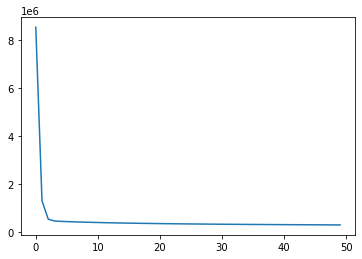

In [20]:
data = loadmat(f'../../Datasets/Arts.mat')
train = data['train']
test = data['test']    

X_test = train[0][0].T
Y_test = train[0][1].T
Y_test[Y_test == -1] = 0

X = torch.from_numpy(test[0][0].T).type(dtype)
Xc = test[0][0].T
Y = torch.from_numpy(test[0][1].T).type(dtype)

Y[Y == -1] = 0

n,d = X.shape
n,c = Y.shape
eps = torch.tensor(torch.finfo(torch.float32).eps)

Alpha = [10]
Beta  = [10]
Gamma = [10]

sig = 10
nn  = 5
ones = torch.ones(n,1)
E    = torch.ones(n,n)
H    =  E - (Ones * Ones.T / n)

SXT,PXT,LXT = SIM_XT(X,sig,nn)
SY,PY,LY = SIM_Y(Y,sig,nn)
Yc = Y.cpu()
Yn = Yc.numpy()

eps = torch.tensor(torch.finfo(torch.float32).eps)
ppn=0


iter = 50
err = torch.zeros(iter)
for a in Alpha:
    for be in Beta:
        for g in Gamma:
            MICAVG = torch.zeros((1))
            MACAVG = torch.zeros((1))
            AVPAVG = torch.zeros((1))
            HMLAVG = torch.zeros((1))
            RNLAVG = torch.zeros((1))
            CVEAVG = torch.zeros((1))
            ZERAVG = torch.zeros((1))   
            AVPAVG = torch.zeros((1))  
            for iv in range(1):
                W = torch.rand(d, c)
                V = torch.rand(n,c)
                for t in range(iter):

                    SVT,PVT,LVT = SIM_VT(V,sig,nn)
                    D = 1/torch.maximum(2 * (torch.abs(Y + V)),eps)

                    Wa =   X.T @ H @ V     + be * (SXT @ W) + g * ( W @ SVT)
                    Wb =   X.T @ H @ X @ W + be * (PXT @ W) + g * ( W @ PVT)
                    W  =    W * (Wa/  torch.maximum(Wb,eps))

                    Va =   H @ X @ W + a * Y         + g * (SY @ V)
                    Vb =   H @ V     + a * (D * (Y + V)) + g * (PY @ V)
                    V  = V * (Va/  torch.maximum(Vb,eps))
                    b = 1/n *(ones.T @ V - ones.T @ X @ W) 

                    T1 = torch.norm(X @ W + ones * b - V,p='fro') ** 2
                    T2 = a * (torch.norm(Y + V,p=1) - 2 * torch.norm(Y * V))
                    T3 = be * torch.trace(W.T@ LXT @ W)
                    T4 = g * (torch.trace(V.T @ LY @ V) + torch.trace(W @ LVT @ W.T ))

                    err[t] = T1 + T2 + T3 + T4
                plt.plot(err)

                WW = torch.norm(W, dim=1, p=2)
                sQ = torch.argsort(WW)
                sQ = sQ.cpu()
                #                     for j in range(13):
                #                         j+=1
                nosf = int (20 * d / 100)
                sX = Xc[:,sQ[d-nosf:]]
                classifier = MLkNN(k=10)
                classifier.fit(sX, Yn.astype(int))
                # predict
                predictions = classifier.predict(X_test[:,sQ[d-nosf:].long()]).toarray()
                scores = classifier.predict_proba(X_test[:,sQ[d-nosf:].long()]).toarray()

                MIC = f1_score(Y_test, predictions, average='micro')
                MICAVG[iv] = MIC
                MAC = f1_score(Y_test, predictions, average='macro')
                MACAVG[iv] = MAC
                AVP = average_precision_score(Y_test.T,scores.T)
                AVPAVG[iv] = AVP
                HML = hamming_loss(Y_test,predictions)
                HMLAVG[iv] = HML
                RNL = label_ranking_loss(Y_test,scores)
                RNLAVG[iv] = RNL
                ZER = zero_one_loss(Y_test,predictions)
                ZERAVG[iv] = ZER
                CVE = coverage_error(Y_test,scores)
                CVEAVG[iv] = CVE
                print('MIC:',MIC,'\n','MAC:',MAC,'\n','AVP:',AVP,'\n','HML:',HML,'\n','RNL:',RNL,'\n','ZER:',ZER,'\n','CVE:',CVE)